In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bnn_shson_rhograd import *
import nn_shson
from shson_exp_manager import *
import h5py

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

x_train = mnist['train_data'][()]
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid = mnist['valid_data'][()]
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test = mnist['test_data'][()]
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()

In [4]:
batch_size = 200

# Blundell version

In [8]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [9]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')


layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [10]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 100
n_batches = len(t_train) / batch_size

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for ep in range(n_epochs):
    bnn.reset_klrw()
    
    for i in range(n_batches):
        bnn.decay_klrw()
#         if (i+1) % 20 == 0:
#             print("klrw index : %g"%(bnn.get_klrw()))
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)
        
#         if i > 50 and np.mean(fs[-50:-25]) < np.mean(fs[-25:]):
#             bnn.decay_lr()
#             print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))
        
            

        if i%50 == 0:
            train_accuracy = bnn.validate(feed)

            print("ep %d, step %d, training accuracy %g"%(ep, i, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
            #print v_q - v_p + v_l

        bnn.train(feed)
    
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    
    summary = sess.run(merged, feed_dict ={bnn.x: x_valid, bnn.t: t_valid})
    test_writer.add_summary(summary, ep)
    
    print("valid accuracy %g"%vacc)
    
    if ep > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
        bnn.decay_lr()
        print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))
    



ep 0, step 0, training accuracy 0.105
f : 53721.7890625, q : -10226.8623047, p : -104833.726562, l : 6629.81591797
ep 0, step 50, training accuracy 0.54
f : 3417.04711914, q : -10203.8320312, p : -104835.492188, l : 3477.75561523
ep 0, step 100, training accuracy 0.71
f : 2253.53833008, q : -10198.5859375, p : -104838.351562, l : 2225.73657227
ep 0, step 150, training accuracy 0.755
f : 1925.98876953, q : -10290.8378906, p : -104840.539062, l : 1966.84912109
ep 0, step 200, training accuracy 0.89
f : 1115.61767578, q : -10120.9882812, p : -104842.226562, l : 1090.51660156
layer0/q_pos/mu:0 (785, 50) (785, 50) <dtype: 'float32_ref'>
layer0/q_pos/rho:0 (785, 50) (785, 50) <dtype: 'float32_ref'>
layer1/q_pos/mu:0 (51, 10) (51, 10) <dtype: 'float32_ref'>
layer1/q_pos/rho:0 (51, 10) (51, 10) <dtype: 'float32_ref'>
valid accuracy 0.8891
ep 1, step 0, training accuracy 0.9
f : 48456.2539062, q : -10061.8984375, p : -104843.648438, l : 1121.96435547
ep 1, step 50, training accuracy 0.865
f : 9

KeyboardInterrupt: 

In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

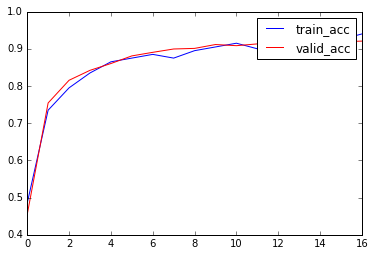

In [9]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

# Online version

In [5]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [6]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [7]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for i in range(n_batches):
    
    bnn.reset_lr()
    
    for ep in range(n_epochs):
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}
        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

        #if ep > 5 and np.mean(fs[-25:]) < np.mean(fs[-15:]):
        if ep > 5 and np.mean(fs[-25:]) < v_f:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3
                
                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
            
            
#             print ("--- learning rate decayed ---")
#             print bnn.get_lr()

        if ep % 50 == 0:
            train_accuracy = bnn.validate(feed)

            print("batch %d, ep %d, training accuracy %g"%(i, ep, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        bnn.train(feed)
        
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
    summary = sess.run(merged, feed_dict ={bnn.x: x_valid, bnn.t: t_valid})
    test_writer.add_summary(summary, i)
    
#     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
#         bnn.decay_lr()
    
    bnn.update_prior()
    #bnn.print_params()
    



batch 0, ep 0, training accuracy 0.1
f : 202075.15625, q : 142556.53125, p : -54964.1367188, l : 4614.22753906
batch 0, ep 50, training accuracy 0.995
f : 195851.8125, q : 140581.421875, p : -55005.390625, l : 338.313293457
batch 0, ep 100, training accuracy 1
f : 193669.015625, q : 138568.765625, p : -55024.6875, l : 83.1640777588
batch 0, ep 150, training accuracy 1
f : 191672.21875, q : 136465.4375, p : -55032.6953125, l : 45.8235168457
valid accuracy 0.7855
batch 1, ep 0, training accuracy 0.845
f : 9938.27929688, q : 134565.203125, p : 125749.96875, l : 1091.68847656
batch 1, ep 50, training accuracy 0.985
f : 320976.34375, q : 134166.890625, p : -186605.125, l : 241.655303955
batch 1, ep 100, training accuracy 0.99
f : 318606.3125, q : 134078.671875, p : -184275.375, l : 215.447280884
batch 1, ep 150, training accuracy 0.99
f : 316796.90625, q : 134001.4375, p : -182541.484375, l : 194.12878418
valid accuracy 0.8274
batch 2, ep 0, training accuracy 0.765
f : 10223.7861328, q : 13

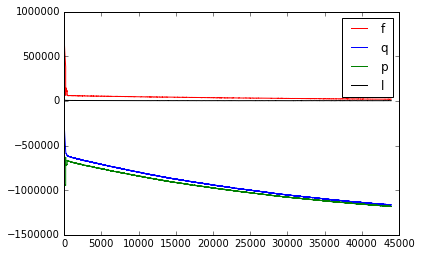

In [9]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

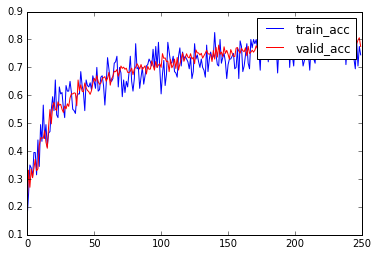

In [8]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

#Online version + EWC with rho_grad

In [5]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [6]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


In [7]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for i in range(n_batches):
    
    bnn.reset_lr()
    
    for ep in range(n_epochs):
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}
        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

        #if ep > 5 and np.mean(fs[-25:]) < np.mean(fs[-15:]):
        if ep > 5 and np.mean(fs[-25:]) < v_f:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3
                
                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
            
            
#             print ("--- learning rate decayed ---")
#             print bnn.get_lr()

        if ep % 50 == 0:
            train_accuracy = bnn.validate(feed)

            print("batch %d, ep %d, training accuracy %g"%(i, ep, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        bnn.train(feed)
    
    
    bnn.print_ewcgrads(feed)
    
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
    summary = sess.run(merged, feed_dict ={bnn.x: x_valid, bnn.t: t_valid})
    test_writer.add_summary(summary, i)
    
#     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
#         bnn.decay_lr()
    
    bnn.update_prior()
    #bnn.print_params()
    



batch 0, ep 0, training accuracy 0.13
f : 202074.671875, q : 142556.53125, p : -54964.109375, l : 4613.77050781
batch 0, ep 50, training accuracy 0.74
f : 197856.96875, q : 140581.453125, p : -54972.4726562, l : 2377.52807617
batch 0, ep 100, training accuracy 0.945
f : 194393.984375, q : 138568.890625, p : -54990.0898438, l : 843.247314453
batch 0, ep 150, training accuracy 0.99
f : 191964.390625, q : 136465.609375, p : -55002.8164062, l : 367.646057129
layer0/q_pos/mu:0
max: 0.574779093266, min: -0.607787549496, mean: 0.000433833221905, std: 0.0849701985717
layer0/q_pos/rho:0
max: -0.983308315277, min: -1.00497055054, mean: -0.995843231678, std: 0.000728058745153
layer1/q_pos/mu:0
max: 2.10006117821, min: -2.11797761917, mean: 8.38649066282e-05, std: 0.771158874035
layer1/q_pos/rho:0
max: -0.960147321224, min: -1.02143192291, mean: -0.995382487774, std: 0.00712784193456
valid accuracy 0.7811
batch 1, ep 0, training accuracy 0.825
f : 9982.43066406, q : 134689.5, p : 125735.742188, l 

In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

#Normal NN

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [8]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

In [9]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for i in range(n_batches):
    
    nn.reset_lr()
    
    for ep in range(n_epochs):
        
        feed = {nn.x: x_train[i*batch_size:(i+1)*batch_size], \
                nn.t: t_train[i*batch_size:(i+1)*batch_size]}
        '''
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)
        '''
        #if ep > 5 and np.mean(fs[-25:]) < np.mean(fs[-15:]):
        if ep > 5 and np.mean(fs[-25:]) < v_f:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3
                
                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
            
            
#             print ("--- learning rate decayed ---")
#             print bnn.get_lr()

        if ep % 50 == 0:
            train_accuracy = nn.validate(feed)

            print("batch %d, ep %d, training accuracy %g"%(i, ep, train_accuracy))
            #print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        nn.train(feed)
    
    
    #bnn.print_ewcgrads(feed)
    
    vacc = nn.validate({nn.x: x_valid, nn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
    summary = sess.run(merged, feed_dict ={nn.x: x_valid, nn.t: t_valid})
    test_writer.add_summary(summary, i)
    
#     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
#         bnn.decay_lr()
    
    #bnn.update_prior()
    #bnn.print_params()
    



0.31326168751822286

In [ ]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

#Normal NN + EWC

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
test_writer = tf.train.SummaryWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for i in range(n_batches):
    
    enn.reset_lr()
    
    for ep in range(n_epochs):
        
        feed = {enn.x: x_train[i*batch_size:(i+1)*batch_size], \
                enn.t: t_train[i*batch_size:(i+1)*batch_size]}
        '''
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)
        '''
        #if ep > 5 and np.mean(fs[-25:]) < np.mean(fs[-15:]):
        if ep > 5 and np.mean(fs[-25:]) < v_f:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3
                
                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
            
            
#             print ("--- learning rate decayed ---")
#             print bnn.get_lr()

        if ep % 50 == 0:
            train_accuracy = enn.validate(feed)

            print("batch %d, ep %d, training accuracy %g"%(i, ep, train_accuracy))
            #print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        enn.train(feed)
    
    
    #bnn.print_ewcgrads(feed)
    
    vacc = enn.validate({enn.x: x_valid, enn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
    summary = sess.run(merged, feed_dict ={enn.x: x_valid, enn.t: t_valid})
    test_writer.add_summary(summary, i)
    
#     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
#         bnn.decay_lr()
    
    enn.update_prior()
    #bnn.print_params()
    



In [ ]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()